# FOOOF Algorithm

<div class="alert alert-success">
This notebook takes a step by step approach, with the code, on how the FOOOF fitting algorithm works.             <br>Note that this notebook is for demonstrative purposes, and does not represent recommended usage of the fooof module.
</div>

<div class="alert alert-info">
To get an introduction to the codebase, go back [here](02-FOOOF.ipynb), or to skip ahead to more code examples, go ahead to [here](04-FOOOFGroup.ipynb).
</div>

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from fooof import FOOOF

# Import some internal functions from FOOOF
from fooof.core.funcs import gaussian_function
from fooof.plts.templates import plot_psd
from fooof.plts.fm import plot_osc_iter

In [2]:
# Set whether to plot in log-log space (used across the whole notebook - change here to propagate)
plt_log = False

In [3]:
# Load example data
freqs = np.load('dat/freqs_2.npy')
psd = np.load('dat/psd_2.npy')

In [4]:
# Initialize FOOOF object
fm = FOOOF(bandwidth_limits=(1, 8), max_n_oscs=6 , min_amp=0.15)

Note that data can be added to FOOF independent of fitting the model, and can then plot input data.

In [5]:
# Add data to FOOOF object
fm.add_data(freqs, psd, [3, 40])

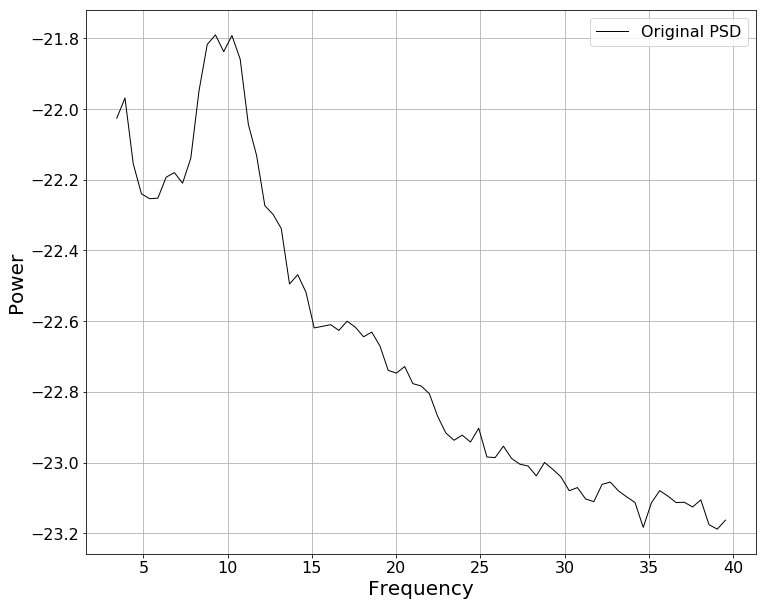

In [6]:
# We start with a raw power-spectrum - lets plot it. 
fm.plot(plt_log)

The FOOOF object stores most of the intermediate steps internally. 

For this notebook, we will first fit the full model, as normal, but then step through, and visualize each step the algorithm takes to come to the final fit. 

In [7]:
# Fit the FOOOF model.
fm.fit(freqs, psd, [3, 40])

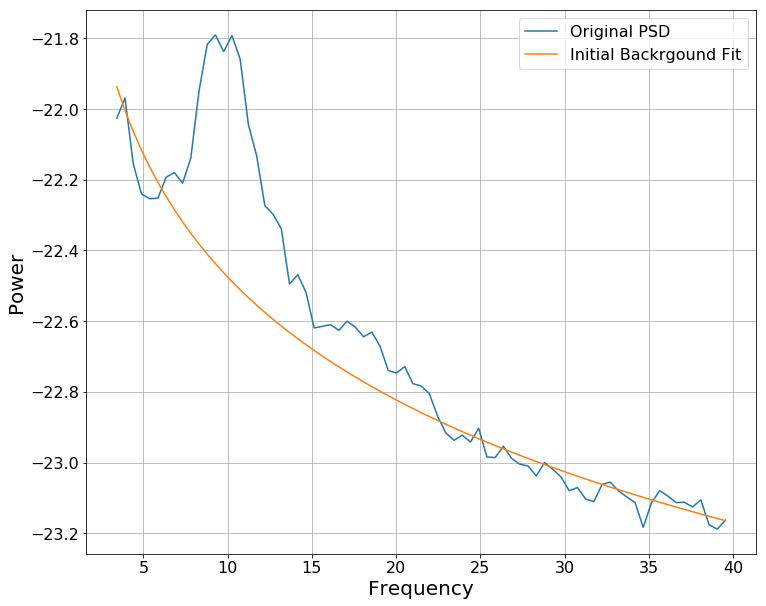

In [8]:
# Initial background fit (this recreates an initial fit that isn't ultimately stored in the FOOOF object)
init_bg_fit = fm._create_bg_fit(fm.freqs, fm._clean_background_fit(fm.freqs, fm.psd))

# Plot the initial background fit
_, ax = plt.subplots(figsize=(12, 10))
plot_psd(fm.freqs, fm.psd, plt_log, label='Original PSD', ax=ax)
plot_psd(fm.freqs, init_bg_fit, plt_log, label='Initial Backrgound Fit', ax=ax)

The initial fit, as above, is used to create a flattened spectrum, from which oscillations can be extracted.

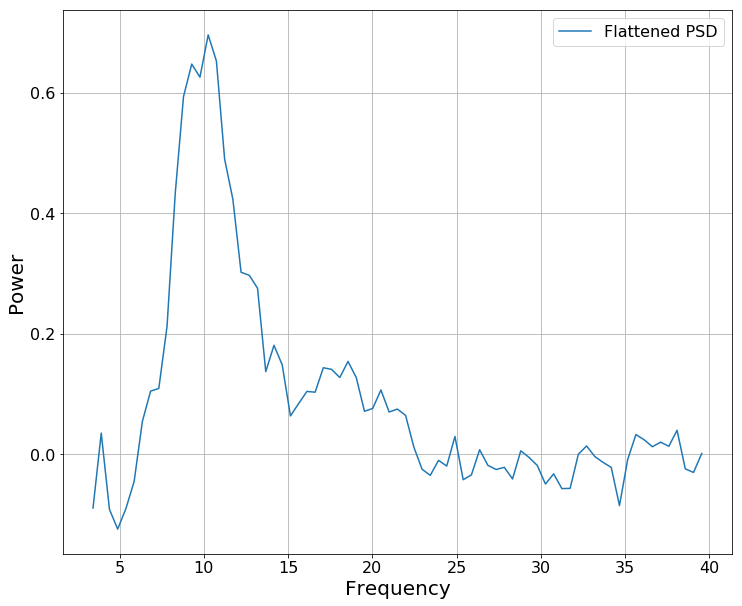

In [9]:
# Flatten the PSD, by subtracting out the initial background fit
plot_psd(fm.freqs, fm._psd_flat, plt_log, label='Flattened PSD')

With the flattened spectrum, FOOOF then initiates an iterative procedure to find oscillations. 

For each iteration:
- The maximum point of the flattened spectrum is found
    - If this point fails to pass the relative or absolute amplitude threshold, the procedure halts
- A gaussian is fit around the maximum point
    - Note that this is a 'guess' gaussian, and not the same fit as the final model fit
- The guess gaussian is subtracted out from the flatted spectrum
- The procedure continues to a new iteration with the new version of the flattend spectrum, unless _max_n_oscs_ has been reached. 

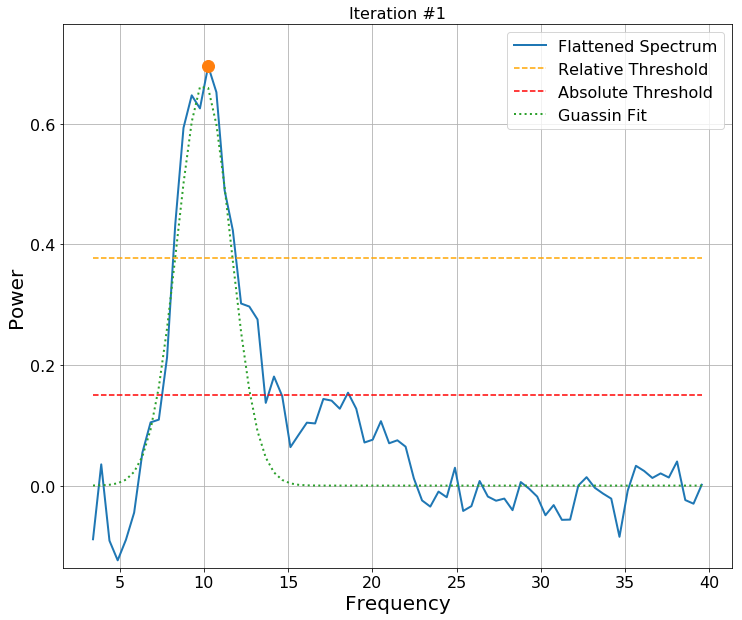

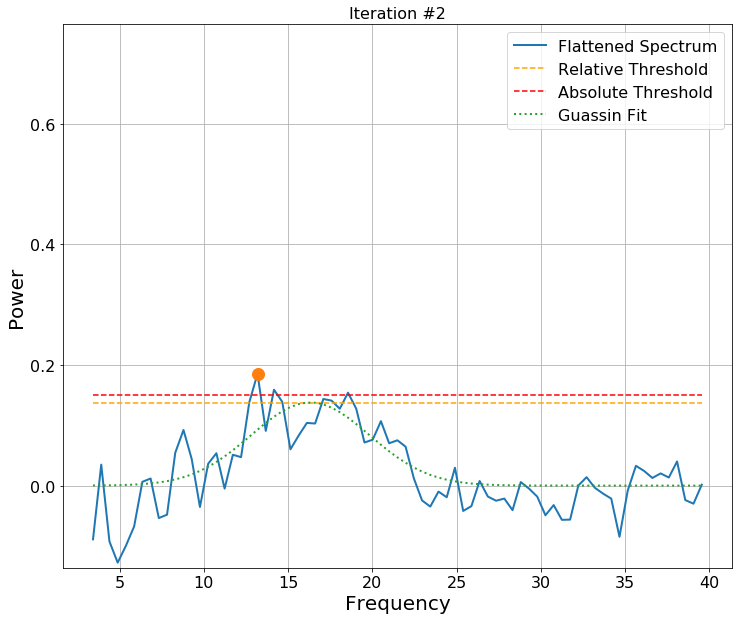

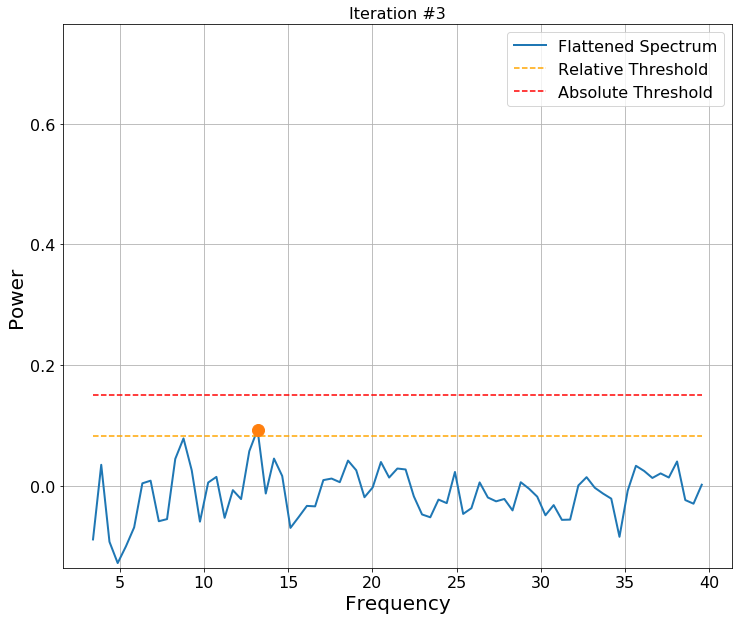

In [10]:
# Plot the iterative approach to finding oscillations from 
plot_osc_iter(fm)

Once the iterative procedure has halted, the extracted 'guess' oscillations, are then re-fit, all together, to the flattened spectrum, creating an oscillation fit. 

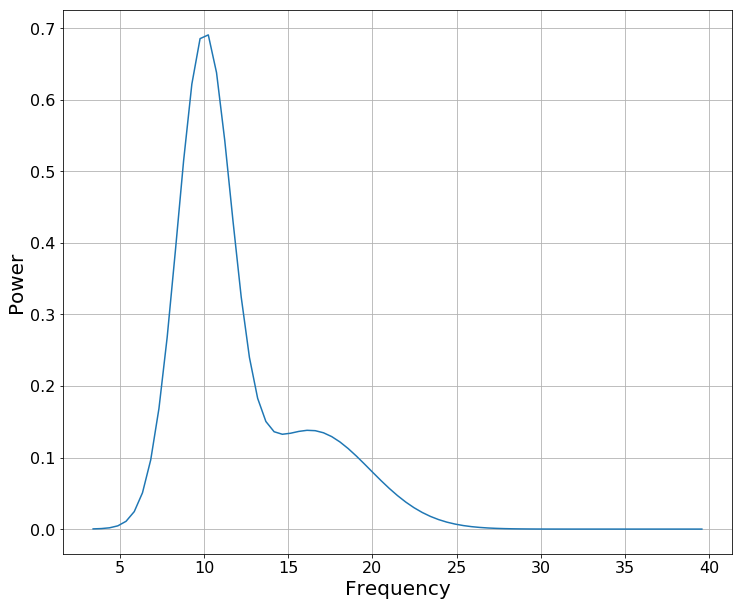

In [11]:
# Fit gaussians to candidate oscillations, and create oscillation fit
plot_psd(fm.freqs, fm._oscillation_fit, plt_log)

This is now the oscillation component of the fit completed. This fit is then used to go back and try and get a better background fit. 

To do so, the oscillation fit is removed from the original PSD, leaving a 'background-only' PSD for re-fitting. 

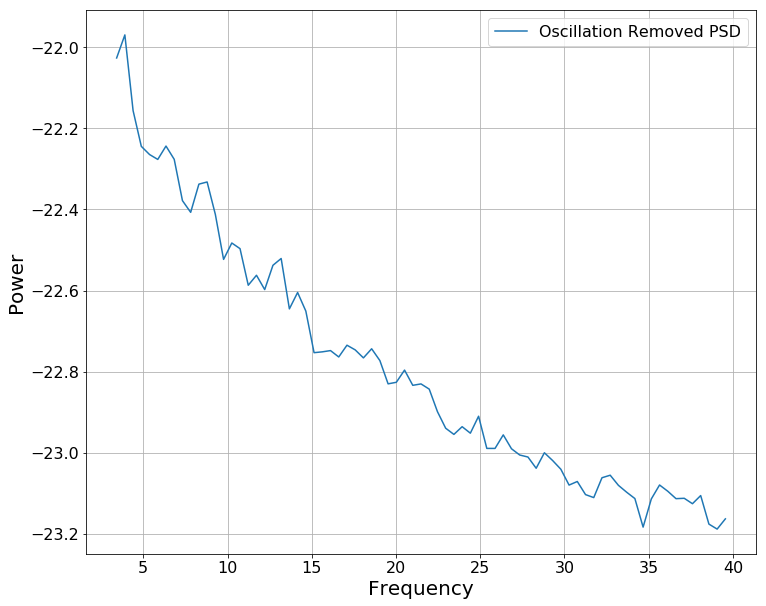

In [12]:
# Create oscillation removed PSD (by removing oscillation fit from original PSD)
plot_psd(fm.freqs, fm._psd_osc_rm, plt_log, label='Oscillation Removed PSD')

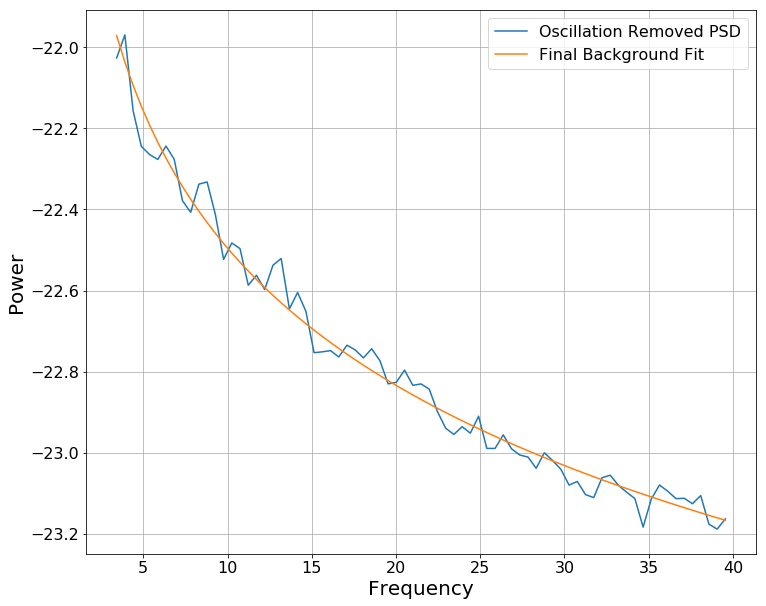

In [13]:
# Fit the final background fit on the oscillation removed PSD
_, ax = plt.subplots(figsize=(12, 10))
plot_psd(fm.freqs, fm._psd_osc_rm, plt_log, label='Oscillation Removed PSD', ax=ax)
plot_psd(fm.freqs, fm._background_fit, plt_log, label='Final Background Fit', ax=ax)

The background fit component of the model is now also complete. The two components can now be combined. 

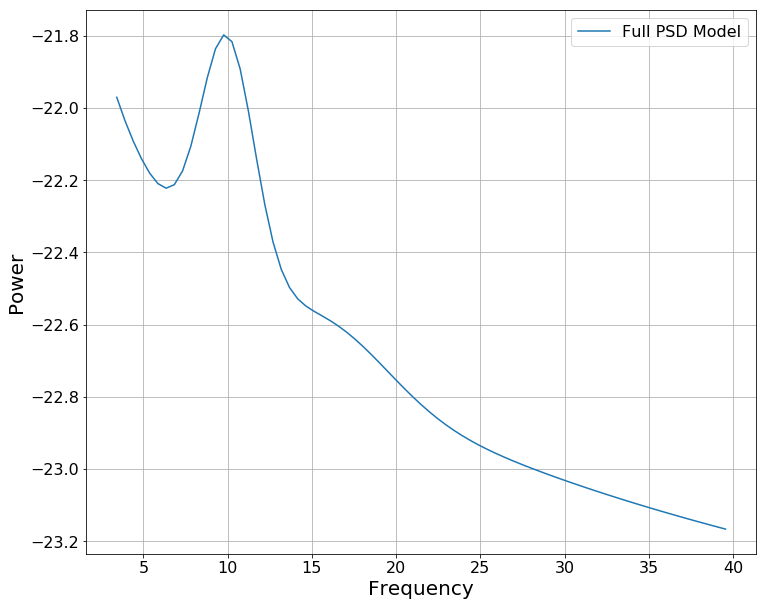

In [14]:
# Recreate the full PSD model, by combining the oscillation & background fits
plot_psd(fm.freqs, fm.psd_fit_, plt_log, label='Full PSD Model')

In [15]:
# The last stage is to calculate the fit error, R^2, and update gaussian parameters -> oscillations parameters
#  These results are part of what are stored, and printed, as the model results
fm.print_results()


                                          FOOOF - PSD MODEL                                         

                    The input PSD was modelled in the frequency range: 3 - 40 Hz                    
                                  Frequency Resolution is 0.49 Hz                                   

                              Background Parameters (offset, slope):                                
                                          -21.3713, 1.1239                                          

                                     2 oscillations were found:                                     
                                 CF:  10.00, Amp:  0.685, BW:  3.18                                 
                                 CF:  16.32, Amp:  0.138, BW:  7.03                                 

                                     R^2 of model fit is 0.9909                                     
                           Root mean squared error of model fit is 0.0332             

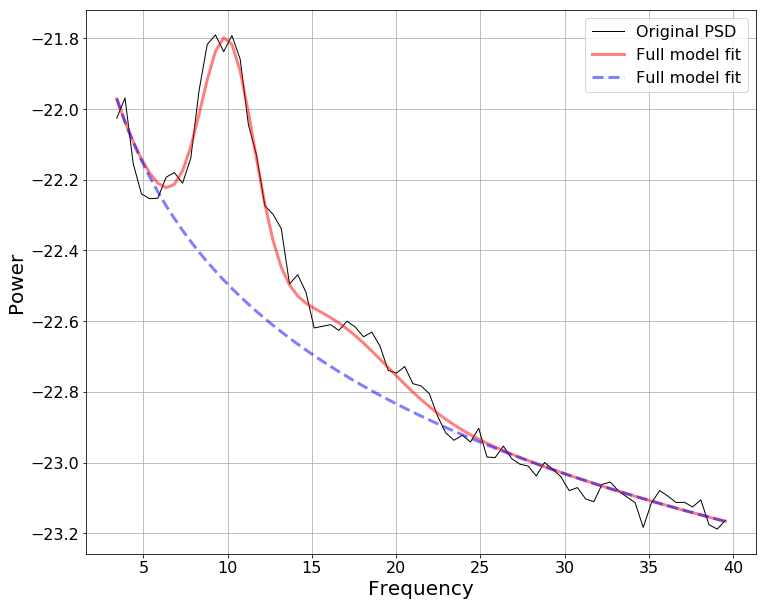

In [16]:
# This final fit, and second background fit, both plotted above, are the same as what are plotted by FOOOF
fm.plot(plt_log)

<div class="alert alert-info">
To continue with the tutorial, exploring the FOOOFGroup object, go [here](04-FOOOFGroup.ipynb).
</div>